## Infra

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 12.4 MB/s eta 0:00:00


In [3]:
import pandas as pd

import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import numpy as np
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh =  mp.solutions.face_mesh
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

from mediapipe.framework.formats.landmark_pb2 import LandmarkList, Landmark

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install moviepy
from moviepy.editor import VideoFileClip

  if event.key is 'enter':



In [6]:
# TFLite model can be loaded and used for prediction
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/content/drive/MyDrive/SIGN/Documentos/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.3 MB/s eta 0:00:00


## Organizing Dataset

In [3]:
videos = pd.read_csv('/content/drive/MyDrive/SIGN/Documentos/video_details.csv') # notice if this is correctly set

train = videos[videos['Type']=='train']
train.drop('Unnamed: 0', axis=1, inplace=True)

# assign number to each sign name
train['sign_ord'] = train['Label'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['Label', 'sign_ord']].set_index('Label').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'Label']].set_index('sign_ord').squeeze().to_dict()

<ipython-input-3-ee9024e974f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Unnamed: 0', axis=1, inplace=True)
<ipython-input-3-ee9024e974f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sign_ord'] = train['Label'].astype('category').cat.codes


In [9]:
project_path = "/content/drive/MyDrive/SIGN/"

In [5]:
df_camara = pd.read_parquet(project_path+"Camara_processed/train/Camara/Camara_1.parquet")

## Function Implementation

In [7]:
df_camara

,type,landmark_index,x,y,z,frame
0,face,0,0.510080,0.324439,-0.010428,8
1,face,1,0.509178,0.299624,-0.021534,8
2,face,2,0.509587,0.306419,-0.010931,8
3,face,3,0.504846,0.274967,-0.016648,8
4,face,4,0.508850,0.292138,-0.023090,8
...,...,...,...,...,...,...
44513506,right_hand,16,0.512024,0.922320,-0.001551,81984
44513507,right_hand,17,0.499433,0.942321,-0.005315,81984
44513508,right_hand,18,0.517635,0.946052,-0.004589,81984
44513509,right_hand,19,0.517371,0.942072,-0.001851,81984


In [8]:
ROWS_PER_FRAME = 543  # number of landmarks per frame (total holistic keypoints)

def load_relevant_data_subset(data):
    data_columns = ['x', 'y', 'z']
    data = data.loc[:,data_columns]
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [10]:
def find_signals(data, window, step, threshold):
  signals = []
  predict_flag = 1
  false_steps = 0
  for i in tqdm(range(0, len(data) - window + 1, step)):
    if predict_flag:
      window_data = data[i:i+window]
      raw_data = load_relevant_data_subset(window_data)
      output = prediction_fn(inputs=raw_data)
      if np.max(output['outputs']) > threshold:
        sign = output['outputs'].argmax()
        signals.append((i,sign))
        predict_flag = 0
        print("sign_predicted")
    else:
      false_steps += 1
      if false_steps > (window/step)/2:
        predict_flag = 1
        false_steps = 0
        print("window_passed")
  return signals

In [42]:
window = 72*ROWS_PER_FRAME
step = 36
threshold = 0.7

In [47]:
sign = find_signals(df_camara.loc[window*10:window*20,:], window, step, threshold)

  0%|          | 0/9775 [00:00<?, ?it/s]

sign_predicted
window_passed
sign_predicted
window_passed
sign_predicted
window_passed
sign_predicted
window_passed
sign_predicted
window_passed


In [48]:
for i in range(0,len(sign)-1):
  print(ORD2SIGN.get(sign[i][1]), f'[{sign[i][1]}]')

Agora [3]
Agora [3]
Agua [4]
Agora [3]


In [49]:
def cortar_video(input_path, output_path, start_frame, end_frame):
    # Carregar o vídeo
    video = VideoFileClip(input_path)

    # Calcular a duração dos frames
    fps = video.fps  # Frames por segundo do vídeo
    start_time = start_frame / fps  # Converter o frame de início para o tempo em segundos
    end_time = end_frame / fps  # Converter o frame de fim para o tempo em segundos

    # Cortar o vídeo
    try:
      video_cortado = video.subclip(start_time, end_time)
    except:
      video_cortado = video.subclip(start_time, video.duration)


    # Salvar o vídeo cortado
    video_cortado.write_videofile(output_path, codec='libx264')

# Exemplo de uso
input_path = "/content/drive/MyDrive/SIGN/Camara/Camara_1.mp4"

for i in range(0,len(sign)-1):
  output_path = f"/content/drive/MyDrive/SIGN/Camara_test/Camara_{ORD2SIGN.get(sign[i][1])}_{i}_test_2.mp4"
  start_frame = round((sign[i][0]/ROWS_PER_FRAME), 0)  # O frame de início
  end_frame = round((sign[i][0]/ROWS_PER_FRAME), 0)+100  # O frame de fim
  cortar_video(input_path, output_path, start_frame, end_frame)


t:  94%|█████████▍| 95/101 [54:05<00:00, 29.98it/s, now=None]

Moviepy - Building video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_0_test_2.mp4.
MoviePy - Writing audio in Camara_Agora_0_test_2TEMP_MPY_wvf_snd.mp3



t:  94%|█████████▍| 95/101 [54:05<00:00, 29.98it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_0_test_2.mp4




t:  94%|█████████▍| 95/101 [54:11<00:00, 29.98it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_0_test_2.mp4


t:  94%|█████████▍| 95/101 [54:12<00:00, 29.98it/s, now=None]

Moviepy - Building video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_1_test_2.mp4.
MoviePy - Writing audio in Camara_Agora_1_test_2TEMP_MPY_wvf_snd.mp3



t:  94%|█████████▍| 95/101 [54:13<00:00, 29.98it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_1_test_2.mp4




t:  94%|█████████▍| 95/101 [54:21<00:00, 29.98it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_1_test_2.mp4


t:  94%|█████████▍| 95/101 [54:22<00:00, 29.98it/s, now=None]

Moviepy - Building video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agua_2_test_2.mp4.
MoviePy - Writing audio in Camara_Agua_2_test_2TEMP_MPY_wvf_snd.mp3



t:  94%|█████████▍| 95/101 [54:22<00:00, 29.98it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agua_2_test_2.mp4




t:  94%|█████████▍| 95/101 [54:28<00:00, 29.98it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/SIGN/Camara_test/Camara_Agua_2_test_2.mp4


t:  94%|█████████▍| 95/101 [54:30<00:00, 29.98it/s, now=None]

Moviepy - Building video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_3_test_2.mp4.
MoviePy - Writing audio in Camara_Agora_3_test_2TEMP_MPY_wvf_snd.mp3



t:  94%|█████████▍| 95/101 [54:30<00:00, 29.98it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_3_test_2.mp4




t:  94%|█████████▍| 95/101 [54:39<00:00, 29.98it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/SIGN/Camara_test/Camara_Agora_3_test_2.mp4


# Visualization

In [7]:
def extract_frames(video_path, SEQUENCE_LENGTH=None):
  """
    Extracts the required frames from after resizing and normalizing them.
    Args:
      video_path: File path of the video to be processed.
    Returns:
      A numpy array containing the extracted frames.
  """
  result = []

  # Read the video file using VideoCapture object
  src = cv2.VideoCapture(str(video_path))

  # Retrieve frame count from VideoCapture object
  video_frame_count = int(src.get(cv2.CAP_PROP_FRAME_COUNT))

  if SEQUENCE_LENGTH:

    # Calculate the frame interval to skip frames and add to the result
    skip_frames_window = max(int(video_frame_count/SEQUENCE_LENGTH), 1)

    for counter in range(SEQUENCE_LENGTH):

      # Set current frame position
      src.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_frames_window)

      ret, frame = src.read()

      # Check if the frame video was successfully read. If not, break.
      if not ret:
        break

      result.append(frame)

  else:
    for counter in range(video_frame_count):

      # Set current frame position
      src.set(cv2.CAP_PROP_POS_FRAMES, counter)

      ret, frame = src.read()

      if not ret:
        break

      result.append(frame)

  # Releace VideoCapture object
  src.release()

  return result

In [12]:
# Load video from MP4 format to array of frames
frames = extract_frames(project_path+"Camara_test/Camara_Agora_0.mp4")

In [13]:
# Load previously processed landmarks from the video
landmarks_df = pd.read_parquet(project_path+"Camara_processed/train/Camara/Camara_1.parquet")

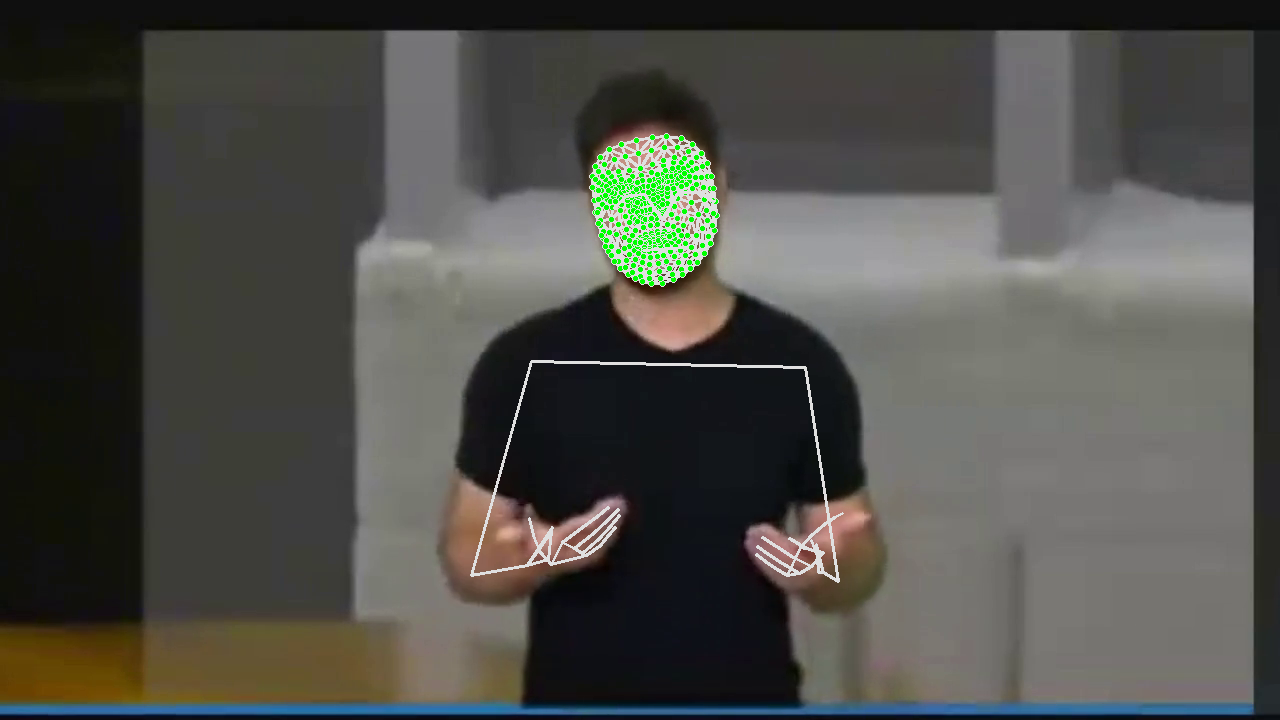

In [18]:
# CHANGE VALUE TO SEE OTHER FRAMES
frame_number = 90

# Filter landmarks for a specigic frame
filtered_landmarks = landmarks_df[landmarks_df["frame"]==frame_number]

actual_frame = frames[frame_number]
image = cv2.cvtColor(actual_frame, cv2.COLOR_BGR2RGB)
image.flags.writeable = True

landmark_types = filtered_landmarks["type"].unique()

for landmark_type in landmark_types:

  type_landmarks = filtered_landmarks[filtered_landmarks["type"]==landmark_type]

  landmarks = []

  for _, row in type_landmarks.iterrows():
    landmarks.append(
        Landmark(
            x=row["x"],
            y=row["y"],
            z=row["z"]
        )
    )
  landmark_list = LandmarkList(landmark=landmarks)

  # Determine the appropriate connections (e.g., face, pose, hand)
  if landmark_type == "face":
    connections = mp_face_mesh.FACEMESH_TESSELATION  # Use FACEMESH_TESSELATION for face
  elif landmark_type == "pose":
      connections = mp_pose.POSE_CONNECTIONS  # Use POSE_CONNECTIONS for pose
  elif landmark_type == "left_hand":
      connections = mp_hands.HAND_CONNECTIONS  # Use HAND_CONNECTIONS for hands
  elif landmark_type == "right_hand":
      connections = mp_hands.HAND_CONNECTIONS  # Use HAND_CONNECTIONS for hands
  else:
      connections = None  # For unsupported types, skip connections

  # Draw the landmarks on the image
  mp_drawing.draw_landmarks(
      image,
      landmark_list,
      connections,
      landmark_drawing_spec= mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=1)
      if landmark_type == "face"
      else None,
  )

img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(img_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()